In [1]:
%run 0_result_analysis_functions.ipynb

In [2]:
# Import catalog with SimstackWrapper
# 2-sf/qt
#combined_pickle_filename = "uVista_DR2_SFQT_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5p0_X_4_foregnd_atonce_"
#prefix='SF_QT__A gt_n35p5_'
# 3-agn
combined_pickle_filename = "uVista_DR2_SFQT_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4p0_X_4_foregnd_atonce_"
prefix='Fratio__A_gt_n35p5_'
# 3-starburst
#combined_pickle_filename = "uVista_DR2_SB_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4p0_X_4_foregnd_layers_"
#prefix='SB__A_gt_n35p5_'
# 4
#combined_pickle_filename = "uVista_DR2_Ahat_Starburst_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5p0_X_4_foregnd_layers_"
#prefix='SB_Ahat__A_gt_n35p5_'

combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", combined_pickle_filename)
underscore_suffix = "" # "__"
path_ini_file = os.path.join(combined_pickle_path+underscore_suffix, "uvista.ini")
path_pickle_file = os.path.join(combined_pickle_path+underscore_suffix, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
fratio_min=0.01

In [4]:
simstack_maps_object = SimstackWrapper(path_ini_file, save_automatically=False, read_maps=True, read_catalog=False)

In [5]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [6]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [7]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [8]:
simstack_object.config_dict['catalog']['classification'].keys()

dict_keys(['redshift', 'stellar_mass', 'agn_fraction', 'split_params'])

In [9]:
fluxes_dict = parse_fluxes(simstack_object)

In [10]:
np.shape(fluxes_dict['flux'])

(7, 8, 4, 3, 2)

In [11]:
# SLOW!
sed_dict = get_fast_sed_dict(simstack_object, fluxes_dict, simstack_catalog_object)

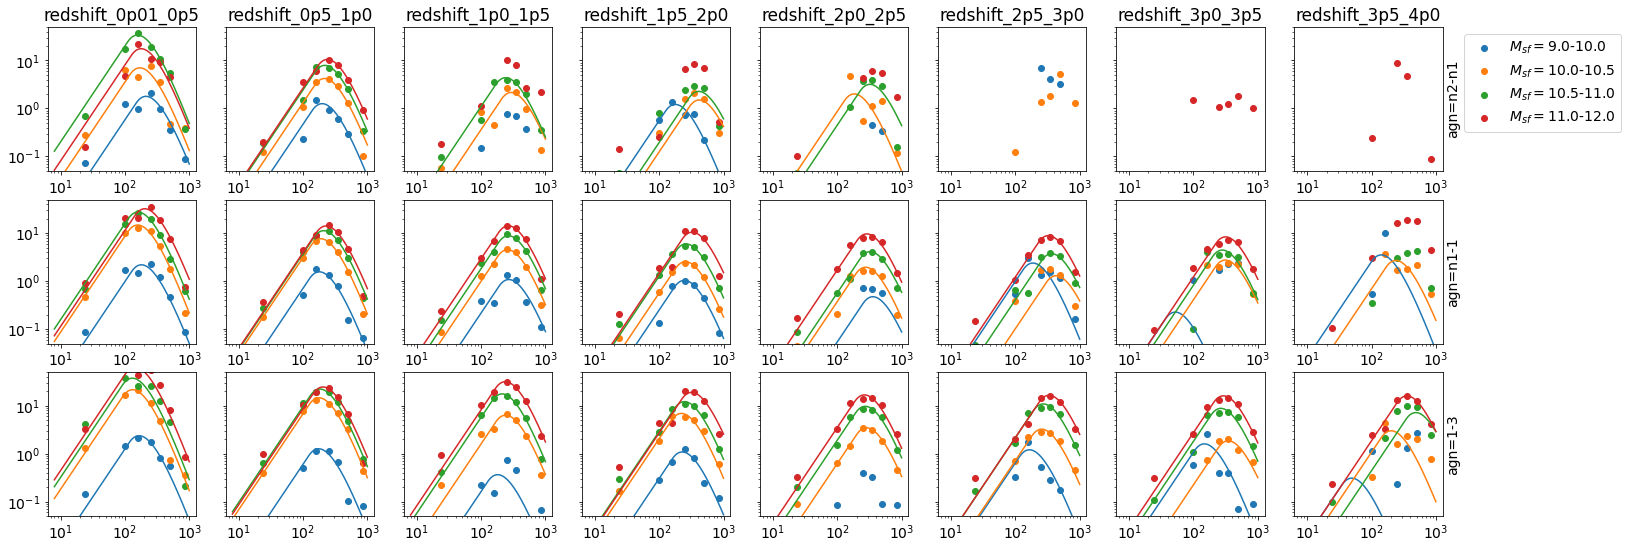

In [12]:
plot_pops(simstack_object,sed_dict=sed_dict)

# Fit model to stacked Fluxes

In [13]:
As_sf = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_0' not in i])
Ts_sf = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_0' not in i])

Ms_sf = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Zs_sf = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_0' not in i])

In [14]:
As_qt = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_1' not in i])
Ts_qt = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_1' not in i])

Ms_qt = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_1' not in i])
Zs_qt = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_1' not in i])

In [15]:
AGNs_sf = np.array([np.log10(sed_dict['agn_fraction'][i]+fratio_min) for i in sed_dict['agn_fraction'] if 'params_0' not in i])
AGNs_qt = np.array([np.log10(sed_dict['agn_fraction'][i]+fratio_min) for i in sed_dict['agn_fraction'] if 'params_1' not in i])

In [16]:
idx_keep_sf = (Zs_sf > 0.1) & (As_sf > -35.5) & (Ts_sf < 65)
cube_sf = np.array([Zs_sf[idx_keep_sf],Ms_sf[idx_keep_sf],AGNs_sf[idx_keep_sf]])
idx_keep_qt = (Zs_qt > 0.1) & (As_qt > -35.5) & (Ts_qt < 65)
cube_qt = np.array([Zs_qt[idx_keep_qt],Ms_qt[idx_keep_qt],AGNs_qt[idx_keep_qt]])

In [17]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_sf = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_sf,),
                     kws={'y': As_sf[idx_keep_sf]},
                     nan_policy='propagate')
cov_Tdust_sf = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_sf,),
                     kws={'y': Ts_sf[idx_keep_sf]},
                     nan_policy='propagate')

In [18]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_qt = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_qt,),
                     kws={'y': As_qt[idx_keep_qt]},
                     nan_policy='propagate')
cov_Tdust_qt = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_qt,),
                     kws={'y': Ts_qt[idx_keep_qt]},
                     nan_policy='propagate')

In [19]:
catalog_keys_sfg = catalog_keys.copy()
catalog_keys_sfg.append('sfg')

In [20]:
idx_sfgs = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 1
idx_qts = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 0

In [21]:
model_cube_sf_agn = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs][catalog_keys]
model_cube_sf_agn['F_ratio']=np.log10(model_cube_sf_agn['F_ratio']+fratio_min)

Z_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['z_peak']
M_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['LMASS']
AGN_model_sf = np.log10(simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['F_ratio']+fratio_min)
ra_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['ra']
dec_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['dec']
uv_sfr_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['SFR_UV']

In [22]:
model_cube_qt_agn = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts][catalog_keys]
model_cube_qt_agn['F_ratio']=np.log10(model_cube_qt_agn['F_ratio']+fratio_min)
  
Z_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['z_peak']
M_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['LMASS']
AGN_model_qt = np.log10(simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['F_ratio']+fratio_min)
ra_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['ra']
dec_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['dec']
uv_sfr_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['SFR_UV']

In [23]:
model_cube_agn = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys_sfg]
model_cube_agn['F_ratio']=np.log10(model_cube_agn['F_ratio']+fratio_min)

Z_model = simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak']
M_model = simstack_catalog_object.catalog_dict['tables']['full_table']['LMASS']
AGN_model = np.log10(simstack_catalog_object.catalog_dict['tables']['full_table']['F_ratio']+fratio_min)
ra_model = simstack_catalog_object.catalog_dict['tables']['full_table']['ra']
dec_model = simstack_catalog_object.catalog_dict['tables']['full_table']['dec']
uv_sfr = simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV']

In [24]:
simstack_catalog_object.catalog_dict['tables']['full_table'].keys()

Index(['ID', 'ra', 'dec', 'mips24', 'z_peak', 'rf_U_V', 'rf_V_J',
       'reddening_AGN', 'a_hat_AGN', 'F_ratio', 'L_UV', 'L_IR', 'SFR_UV',
       'LMASS', 'parent_id', 'parent', 'sfg'],
      dtype='object')

In [25]:
Ahat_model = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN']

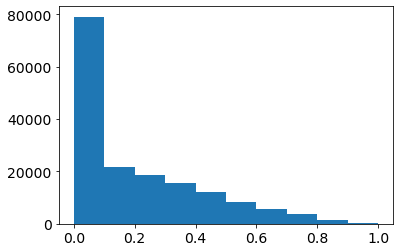

In [26]:
abins = None
plt.hist(Ahat_model,bins=abins);

In [27]:
model_cube_sf_agn = model_cube_sf_agn.to_numpy().T
model_cube_qt_agn = model_cube_qt_agn.to_numpy().T
model_cube_agn = model_cube_agn.to_numpy().T

In [28]:
model_cube_sf = model_cube_sf_agn.copy() # rename model_cube to model_cube_agn
model_cube_qt = model_cube_qt_agn.copy() # nonsense, need to rename model_cube_qt to model_cube_agn_qt
model_cube = model_cube_agn.copy() # nonsense, need to rename model_cube_qt to model_cube_agn_qt
model_cube_sf[2] = np.log10(fratio_min) #0
model_cube_qt[2] = np.log10(fratio_min) # 0
model_cube[2] = np.log10(fratio_min) # 0

In [29]:
A_model_sf_agn = model_A_Tdust(cov_Adust_sf.params, model_cube_sf_agn)
T_model_sf_agn = model_A_Tdust(cov_Tdust_sf.params, model_cube_sf_agn)
#sed_model_params_sf_agn = {'A':cov_Adust_sf.params, 'Tdust':cov_Tdust_sf.params}

In [30]:
A_model_qt_agn = model_A_Tdust(cov_Adust_qt.params, model_cube_qt_agn)
T_model_qt_agn = model_A_Tdust(cov_Tdust_qt.params, model_cube_qt_agn)
#sed_model_params_qt_agn = {'A':cov_Adust_qt.params, 'Tdust':cov_Tdust_qt.params}

## Fit parameters directly to maps?

In [31]:
idx_sim_sf = ((A_model_sf_agn > -36) & (A_model_sf_agn < -32)) 
idx_sim_qt = ((A_model_qt_agn > -36) & (A_model_qt_agn < -32)) 

In [32]:
idx_sim_sf = (A_model_sf_agn > -35.5) & (A_model_sf_agn < -32) & (T_model_sf_agn < 65) & (Z_model_sf > 0.1) #& (AGN_model_sf > 0) 
idx_sim_qt = (A_model_qt_agn > -35.5) & (A_model_qt_agn < -32) & (T_model_qt_agn < 65) & (Z_model_qt > 0.1) #& (AGN_model_qt > 0) 

In [33]:
map_dict_sf = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf[idx_sim_sf], dec_model_sf[idx_sim_sf])
    #x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords'] = [x,y]
    map_dict_sf[map_key]=map_object

In [34]:
map_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    map_object['map_coords']={}
    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords']['sf'] = [x_sf,y_sf]
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords']['qt'] = [x_qt,y_qt]
    map_dict[map_key]=map_object

In [35]:
def direct_convolved_fit_A_Tdust_sf(params, X, y):

    v = params.valuesdict()#.copy()
    A_model = v.pop('A_offset')
    T_model = v.pop('T_offset')
    Z_model = X[0]
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            A_model+= X[i] * v[ival]
        else:
            T_model+= X[i] * v[ival]
            i+=1
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords = y[map_name]['map_coords']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model = get_map_flux_mJy(np.array([map_nu]),A_model,T_model/(1+Z_model))
        map_model[map_coords[0],map_coords[1]]+=S_model
        map_pixels[map_coords[0],map_coords[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

In [36]:
def direct_convolved_fit_A_Tdust(params, X, y):

    v = params.valuesdict()#.copy()
    A_model_sf = v.pop('A_offset_sf')
    T_model_sf = v.pop('T_offset_sf')
    A_model_qt = v.pop('A_offset_qt')
    T_model_qt = v.pop('T_offset_qt')
    idx_sf = X[-1] == 1
    idx_qt = X[-1] == 0
    Z_model_sf = X[0][idx_sf]
    Z_model_qt = X[0][idx_qt]
    
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            if 'sf' in ival:
                A_model_sf+= X[i][idx_sf] * v[ival]
            else:
                A_model_qt+= X[i][idx_qt] * v[ival]
        else:
            if 'sf' in ival:
                T_model_sf+= X[i][idx_sf] * v[ival]
            else:
                T_model_qt+= X[i][idx_qt] * v[ival]
                i+=1
                
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords_sf = y[map_name]['map_coords']['sf']
        map_coords_qt = y[map_name]['map_coords']['qt']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)

        S_model_sf = get_map_flux_mJy(np.array([map_nu]),A_model_sf,T_model_sf/(1+Z_model_sf))
        S_model_qt = get_map_flux_mJy(np.array([map_nu]),A_model_qt,T_model_qt/(1+Z_model_qt))
        
        #pdb.set_trace()
        map_model[map_coords_sf[0],map_coords_sf[1]]+=S_model_sf
        map_model[map_coords_qt[0],map_coords_qt[1]]+=S_model_qt
        map_pixels[map_coords_sf[0],map_coords_sf[1]]+=1
        map_pixels[map_coords_qt[0],map_coords_qt[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

# Fit just SF simultaneously

In [37]:
#These are the initial guesses
cov_Adust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,-43.3446863,0.84279850,(1.94%),0.001301565573726959,-inf,inf,True
slope_redshift,0.21991685,0.04273505,(19.43%),1.4,-inf,inf,True
slope_stellar_mass,0.82351316,0.08048063,(9.77%),0.0007346990812472507,-inf,inf,True
slope_agn_fraction,0.01592309,0.03984754,(250.25%),5.1963617887206376e-05,-inf,inf,True


In [38]:
# Define Fit Parameters
fit_params_sf = Parameters()
fit_params_sf.add('A_offset', value=cov_Adust_sf.params['offset'].value)
fit_params_sf.add('T_offset', value=cov_Tdust_sf.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sf.add('A_slope_'+key, value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_sf.add('T_slope_'+key, value=cov_Tdust_sf.params['slope_'+key].value)
    
cov_direct_fit_sf = minimize(direct_convolved_fit_A_Tdust_sf, fit_params_sf,
                     args=(model_cube_sf_agn[:,idx_sim_sf],),
                     kws={'y':map_dict_sf},
                     nan_policy='propagate')

In [39]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-43.6829375,0.05224890,(0.12%),-43.34468632061312,-inf,inf,True
T_offset,58.2980831,0.73095640,(1.25%),48.96657348218544,-inf,inf,True
A_slope_redshift,0.14741386,0.00308385,(2.09%),0.21991684807107006,-inf,inf,True
T_slope_redshift,5.77106254,0.04748046,(0.82%),5.270127529875174,-inf,inf,True
A_slope_stellar_mass,0.86445424,0.00500342,(0.58%),0.8235131586477165,-inf,inf,True
T_slope_stellar_mass,-3.56802640,0.06928548,(1.94%),-2.5486783243186903,-inf,inf,True
A_slope_agn_fraction,0.11985860,0.00328793,(2.74%),0.015923089727578426,-inf,inf,True
T_slope_agn_fraction,0.61081773,0.04386596,(7.18%),1.6608358895149273,-inf,inf,True


In [40]:
vT_just_sf = cov_direct_fit_sf.params.copy()
vA_just_sf = cov_direct_fit_sf.params.copy()
vT_just_qt = cov_direct_fit_sf.params.copy()
vA_just_qt = cov_direct_fit_sf.params.copy()

Alist = [i for i, j in vA_just_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_just_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_just_sf.pop(i) for i in Tlist]
Tpop=[vT_just_sf.pop(i) for i in Alist]

In [41]:
A_combined_model_just_sf_agn = model_A_or_Tdust(vA_just_sf, model_cube_sf_agn)
T_combined_model_just_sf_agn = model_A_or_Tdust(vT_just_sf, model_cube_sf_agn)

In [42]:
A_combined_model_just_sf = model_A_or_Tdust(vA_just_sf, model_cube_sf)
T_combined_model_just_sf = model_A_or_Tdust(vT_just_sf, model_cube_sf)

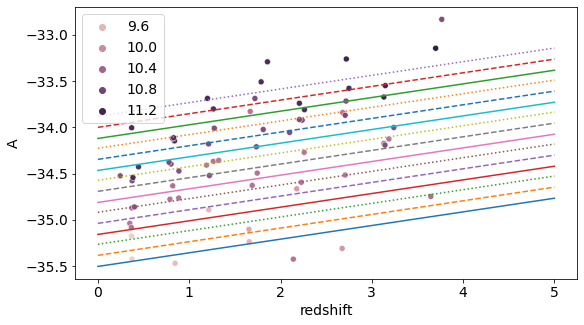

In [43]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

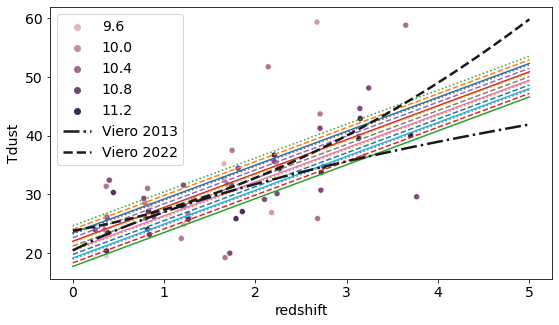

In [44]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)

plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

In [45]:
combined_theta_model_just_sf_agn = A_combined_model_just_sf_agn, np.array(T_combined_model_just_sf_agn / (1+Z_model_sf))

In [46]:
combined_theta_model_just_sf= A_combined_model_just_sf, np.array(T_combined_model_just_sf / (1+Z_model_sf))

# Now fit SF and QT simultaneously

In [47]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=cov_Adust_sf.params['offset'].value)
fit_params_sfg.add('T_offset_sf', value=cov_Tdust_sf.params['offset'].value)
fit_params_sfg.add('A_offset_qt', value=cov_Adust_qt.params['offset'].value)
fit_params_sfg.add('T_offset_qt', value=cov_Tdust_qt.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sfg.add('A_slope_'+key+'_sf', value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=cov_Tdust_sf.params['slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=cov_Adust_qt.params['slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=cov_Tdust_qt.params['slope_'+key].value)
    
cov_direct_fit_agn = minimize(direct_convolved_fit_A_Tdust, fit_params_sfg,
                     args=(model_cube_agn,),
                     kws={'y':map_dict},
                     nan_policy='propagate')

In [48]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-43.6868406,0.05222074,(0.12%),-43.3446872233276,-inf,inf,True
T_offset,58.3562394,0.73057134,(1.25%),48.96656472340865,-inf,inf,True
A_slope_redshift,0.14723105,0.00309151,(2.10%),0.21991693504531243,-inf,inf,True
T_slope_redshift,5.77329472,0.04757998,(0.82%),5.270127330135216,-inf,inf,True
A_slope_stellar_mass,0.86483355,0.00500063,(0.58%),0.8235132398897064,-inf,inf,True
T_slope_stellar_mass,-3.57364278,0.06924552,(1.94%),-2.5486774653533844,-inf,inf,True
A_slope_agn_fraction,0.11999266,0.00330862,(2.76%),0.015922795813967213,-inf,inf,True
T_slope_agn_fraction,0.60960642,0.04420537,(7.25%),1.6608360028557108,-inf,inf,True


In [49]:
cov_direct_fit_agn.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-43.3428168,0.04126346,(0.10%),-43.3446872233276,-inf,inf,True
T_offset_sf,49.1133673,0.57996763,(1.18%),48.96656472340865,-inf,inf,True
A_offset_qt,-35.6704420,0.23415956,(0.66%),-35.75302435870378,-inf,inf,True
T_offset_qt,-7.90295989,2.69123055,(34.05%),-6.220304476728641,-inf,inf,True
A_slope_redshift_sf,0.15709529,0.00259341,(1.65%),0.21991693504531243,-inf,inf,True
T_slope_redshift_sf,5.63328630,0.04098965,(0.73%),5.270127330135216,-inf,inf,True
A_slope_redshift_qt,0.22563071,0.01141993,(5.06%),0.07319467338950965,-inf,inf,True
T_slope_redshift_qt,6.84756537,0.18425498,(2.69%),10.817686146178154,-inf,inf,True
A_slope_stellar_mass_sf,0.83101142,0.00396145,(0.48%),0.8235132398897064,-inf,inf,True
T_slope_stellar_mass_sf,-2.69261092,0.05521621,(2.05%),-2.5486774653533844,-inf,inf,True


In [40]:
cov_direct_fit_agn.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-42.4398505,0.03538589,(0.08%),-42.64318087216746,-inf,inf,True
T_offset_sf,29.5816058,0.45672174,(1.54%),26.84135565979871,-inf,inf,True
A_offset_qt,-38.1930744,0.58019869,(1.52%),-33.71125555979274,-inf,inf,True
T_offset_qt,-9.68435766,6.56577985,(67.80%),4.7637636516833,-inf,inf,True
A_slope_redshift_sf,0.19303501,0.00236579,(1.23%),0.16814222001929766,-inf,inf,True
T_slope_redshift_sf,6.10997296,0.03917274,(0.64%),6.296034083082391,-inf,inf,True
A_slope_redshift_qt,0.27574236,0.01796219,(6.51%),0.5591615815727093,-inf,inf,True
T_slope_redshift_qt,9.40850309,0.27356751,(2.91%),4.624726103296203,-inf,inf,True
A_slope_stellar_mass_sf,0.74552784,0.00340927,(0.46%),0.7663627339358039,-inf,inf,True
T_slope_stellar_mass_sf,-0.89861942,0.04372384,(4.87%),-0.6200347584137597,-inf,inf,True


In [50]:
vT_sf_agn = cov_direct_fit_agn.params.copy()
vA_sf_agn = cov_direct_fit_agn.params.copy()
vT_qt_agn = cov_direct_fit_agn.params.copy()
vA_qt_agn = cov_direct_fit_agn.params.copy()

Alist = [i for i, j in vA_sf_agn.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_sf_agn.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_sf_agn.pop(i) for i in Tlist]
Tpop=[vT_sf_agn.pop(i) for i in Alist]

Alist_qt = [i for i, j in vA_qt_agn.items() if (('A_' in i) or ('_sf' in i))]
Tlist_qt = [i for i, j in vT_qt_agn.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_qt_agn.pop(i) for i in Tlist_qt]
Tpop=[vT_qt_agn.pop(i) for i in Alist_qt]

In [52]:
vA_sf_agn

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-43.3428168,0.04126346,(0.10%),-43.3446872233276,-inf,inf,True
A_slope_redshift_sf,0.15709529,0.00259341,(1.65%),0.21991693504531243,-inf,inf,True
A_slope_stellar_mass_sf,0.83101142,0.00396145,(0.48%),0.8235132398897064,-inf,inf,True
A_slope_agn_fraction_sf,0.12560187,0.00275139,(2.19%),0.015922795813967213,-inf,inf,True


In [53]:
A_combined_model_sf_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn)
T_combined_model_sf_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn)

A_combined_model_qt_agn = model_A_or_Tdust(vA_qt_agn, model_cube_qt_agn)
T_combined_model_qt_agn = model_A_or_Tdust(vT_qt_agn, model_cube_qt_agn)

In [86]:
A_combined_model_sf = model_A_or_Tdust(vA_sf_agn, model_cube_sf)
T_combined_model_sf = model_A_or_Tdust(vT_sf_agn, model_cube_sf)

A_combined_model_qt = model_A_or_Tdust(vA_qt_agn, model_cube_qt)
T_combined_model_qt = model_A_or_Tdust(vT_qt_agn, model_cube_qt)

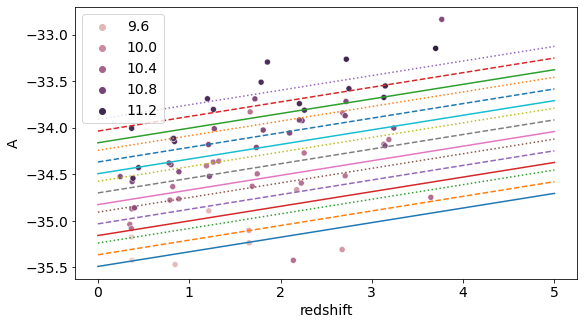

In [55]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_sf_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_sf_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

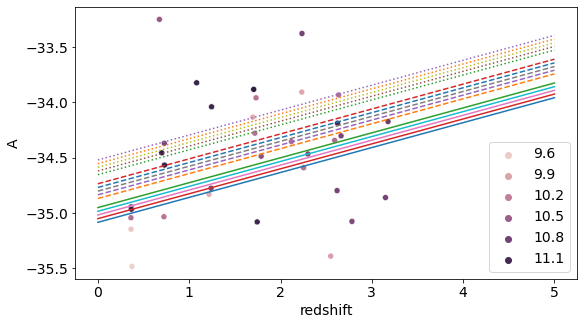

In [56]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],As_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_qt_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_qt_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

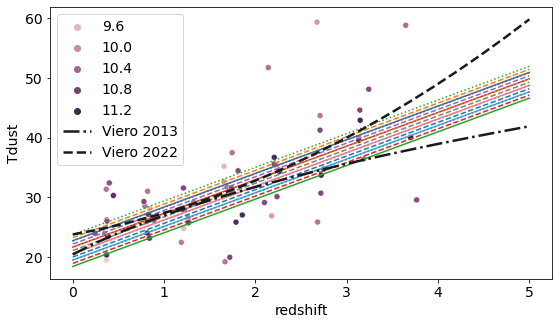

In [93]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_sf_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_sf_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

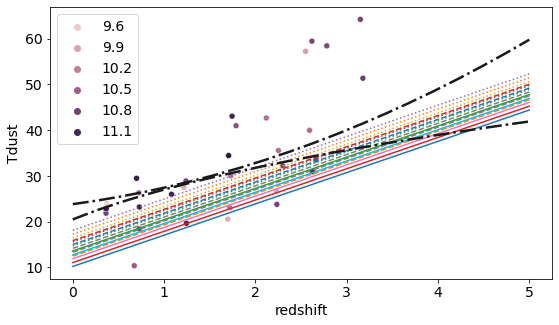

In [81]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],Ts_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_qt_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_qt_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

# Decompose LIR into AGN and non-AGN

In [60]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

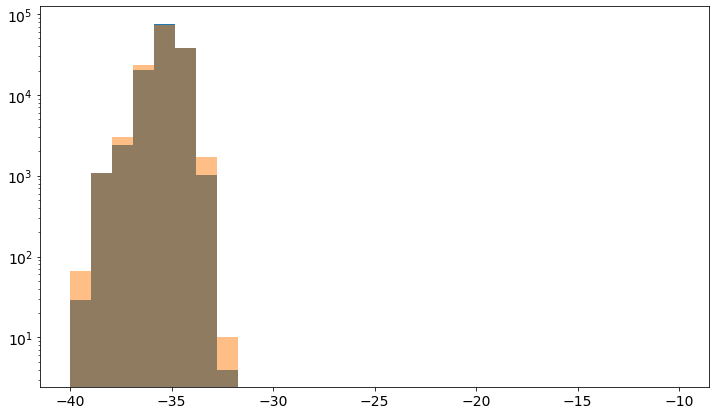

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(12,7))
hbins=np.linspace(-40,-10,30)
plt.hist(A_combined_model_sf, bins=hbins);
plt.hist(A_combined_model_sf_agn, bins=hbins, alpha=0.5);
plt.yscale('log')

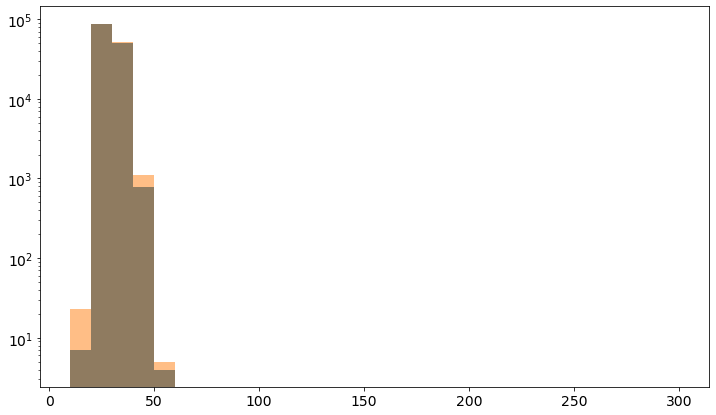

In [62]:
fig, axs = plt.subplots(1, 1, figsize=(12,7))
hbins=np.linspace(10,300,30)
plt.hist(T_combined_model_sf, bins=hbins);
plt.hist(T_combined_model_sf_agn, bins=hbins, alpha=0.5);
plt.yscale('log')

In [63]:
combined_theta_model_sf_agn = A_combined_model_sf_agn, np.array(T_combined_model_sf_agn / (1+Z_model_sf))
combined_theta_model_qt_agn = A_combined_model_qt_agn, np.array(T_combined_model_qt_agn / (1+Z_model_qt))

In [87]:
combined_theta_model_sf= A_combined_model_sf, np.array(T_combined_model_sf / (1+Z_model_sf))
combined_theta_model_qt = A_combined_model_qt, np.array(T_combined_model_qt / (1+Z_model_qt))

In [65]:
LIR_model_just_sf_agn = fast_LIR(simstack_object, combined_theta_model_just_sf_agn, Z_model_sf)

In [66]:
LIR_model_just_sf = fast_LIR(simstack_object, combined_theta_model_just_sf, Z_model_sf)

In [88]:
LIR_model_sf = fast_LIR(simstack_object, combined_theta_model_sf, Z_model_sf)

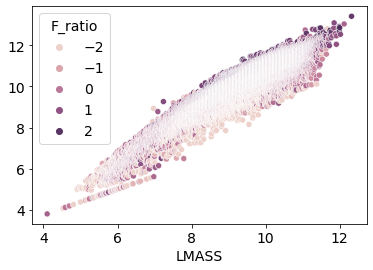

In [98]:
sns.scatterplot(M_model_sf, np.log10(LIR_model_sf), hue=AGN_model_sf);

In [89]:
LIR_model_qt = fast_LIR(simstack_object, combined_theta_model_qt, Z_model_qt)

In [69]:
LIR_model_sf_agn = fast_LIR(simstack_object, combined_theta_model_sf_agn, Z_model_sf)

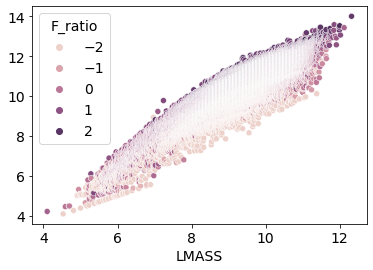

In [99]:
sns.scatterplot(M_model_sf, np.log10(LIR_model_sf_agn), hue=AGN_model_sf);

In [70]:
LIR_model_qt_agn = fast_LIR(simstack_object, combined_theta_model_qt_agn, Z_model_qt)

In [71]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=10000, replace=False)

In [72]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=10000, replace=False)

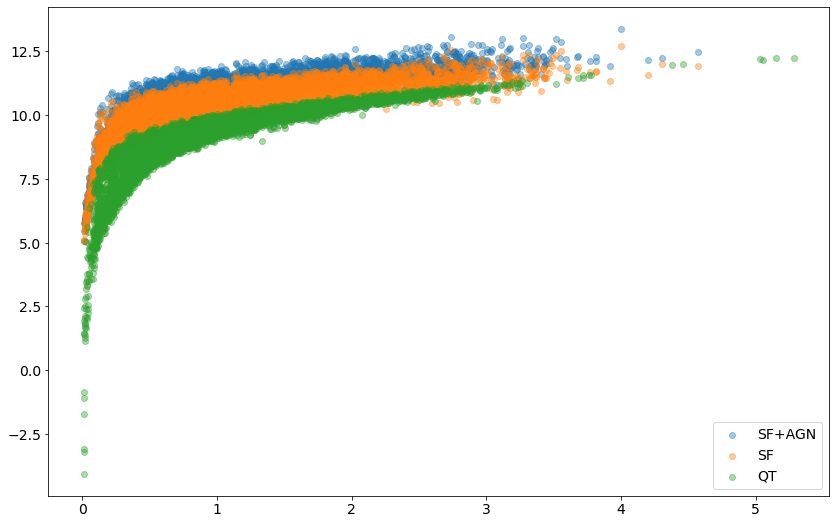

In [90]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), alpha=0.4, label='SF+AGN');
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

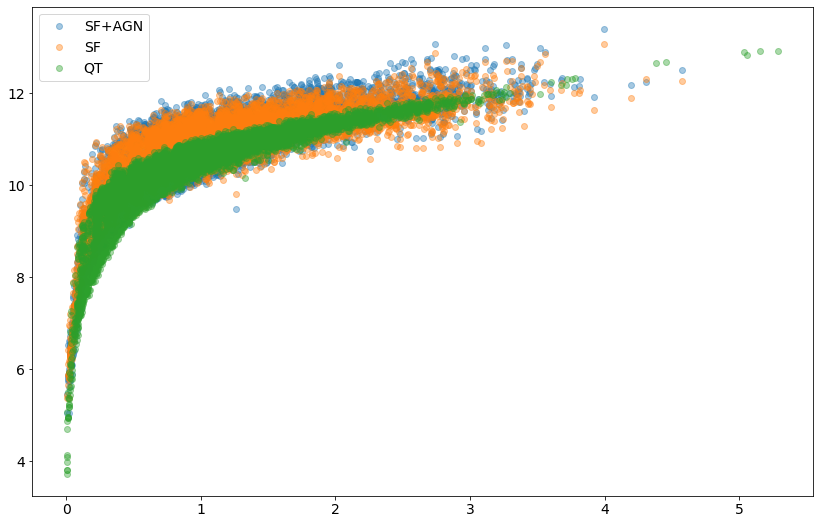

In [73]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), alpha=0.4, label='SF+AGN');
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

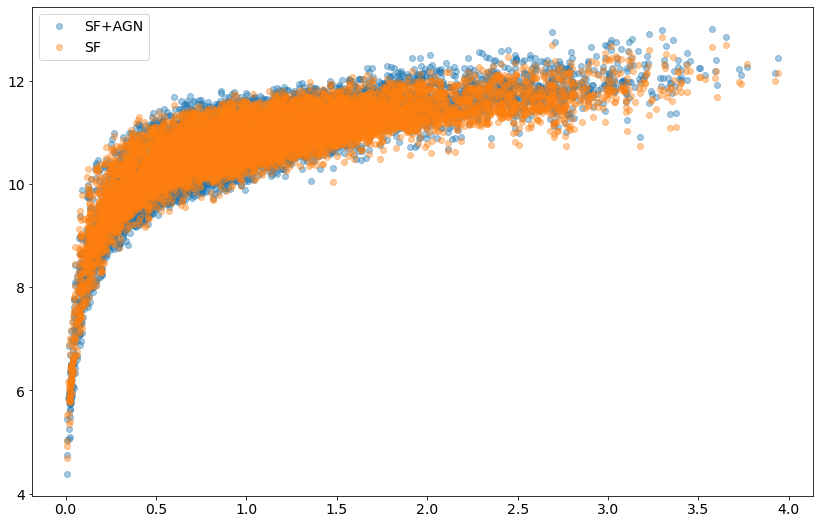

In [60]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), alpha=0.4, label='SF+AGN');
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
#plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

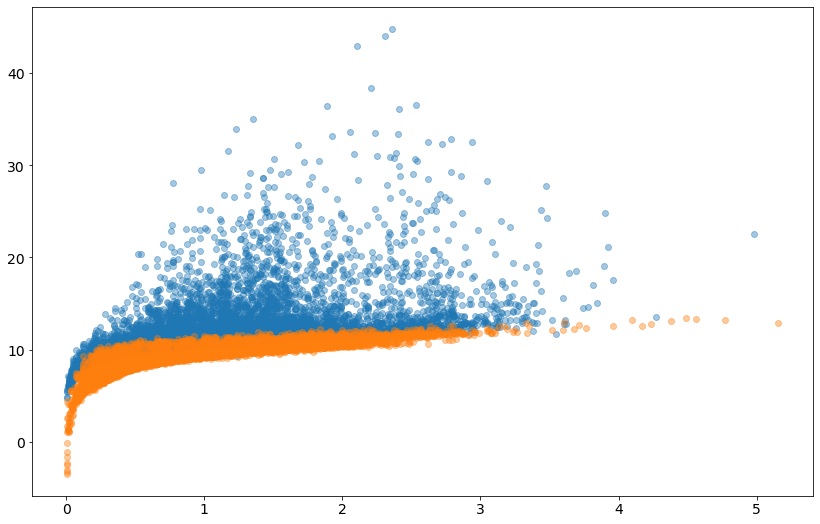

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), alpha=0.4);
plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt_agn[idx_sample_qt]), alpha=0.4);

In [91]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_just_sf_agn = np.zeros(len(zbins)-1)
binned_lir_just_sf = np.zeros(len(zbins)-1)
binned_lir_sf_agn = np.zeros(len(zbins)-1)
binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt_agn = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)

binned_uv_sfr_sf = np.zeros(len(zbins)-1)
binned_uv_sfr_qt = np.zeros(len(zbins)-1)
binned_uv_sfr = np.zeros(len(zbins)-1)

binned_vol = np.zeros(len(zbins)-1)
area_deg2 = 1.8 #1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    
    binned_lir_just_sf_agn[iz] = np.sum(LIR_model_just_sf_agn[idx_z_sf],axis=0)
    binned_lir_just_sf[iz] = np.sum(LIR_model_just_sf[idx_z_sf],axis=0)
    
    binned_lir_sf_agn[iz] = np.sum(LIR_model_sf_agn[idx_z_sf],axis=0)
    binned_lir_sf[iz] = np.sum(LIR_model_sf[idx_z_sf],axis=0)
    binned_lir_qt_agn[iz] = np.sum(LIR_model_qt_agn[idx_z_qt],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt[idx_z_qt],axis=0)
    
    binned_uv_sfr_sf[iz] = np.sum(uv_sfr_sf[idx_z_sf])
    binned_uv_sfr_qt[iz] = np.sum(uv_sfr_qt[idx_z_qt])
    
    idx_z_whole = (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] > zbins[iz]) & (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] <= zbins[iz+1])
    binned_uv_sfr[iz] = np.sum(simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV'][idx_z_whole])
    
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

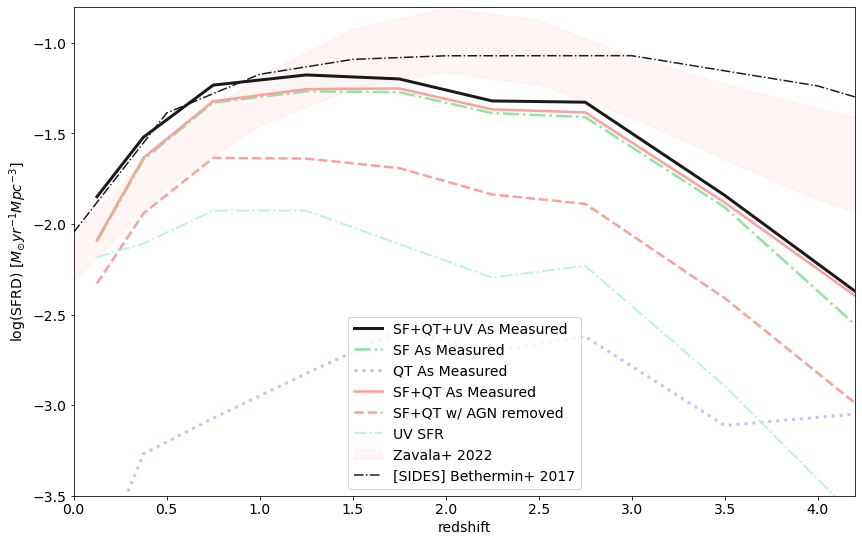

In [92]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=3, label='SF+QT+UV As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn))/binned_vol), '-.g', lw=2.5, label='SF As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), ':m', lw=3, label='QT As Measured')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn))/binned_vol), '-r', lw=2.5, label='SF+QT As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt))/binned_vol), '--r', lw=2.5, label='SF+QT w/ AGN removed')

#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.c', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='k', lw=1.5, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

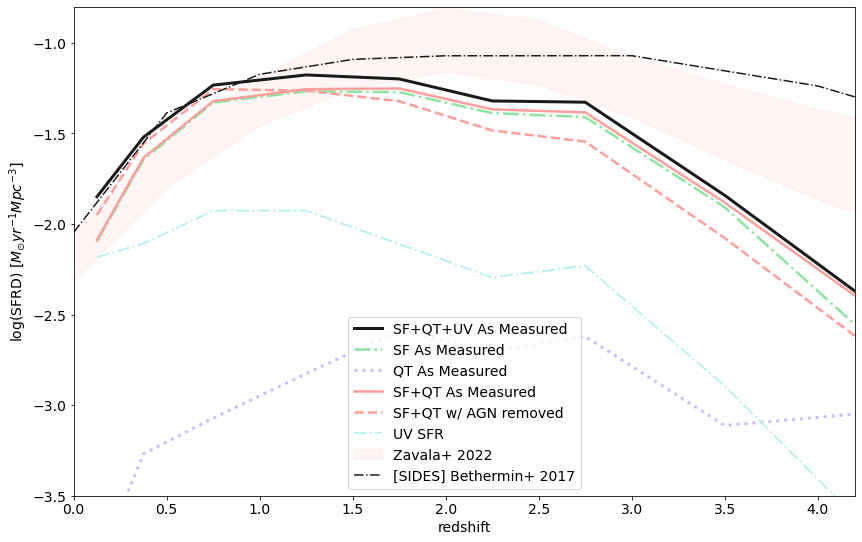

In [75]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=3, label='SF+QT+UV As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn))/binned_vol), '-.g', lw=2.5, label='SF As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), ':m', lw=3, label='QT As Measured')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn))/binned_vol), '-r', lw=2.5, label='SF+QT As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt))/binned_vol), '--r', lw=2.5, label='SF+QT w/ AGN removed')

#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.c', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='k', lw=1.5, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

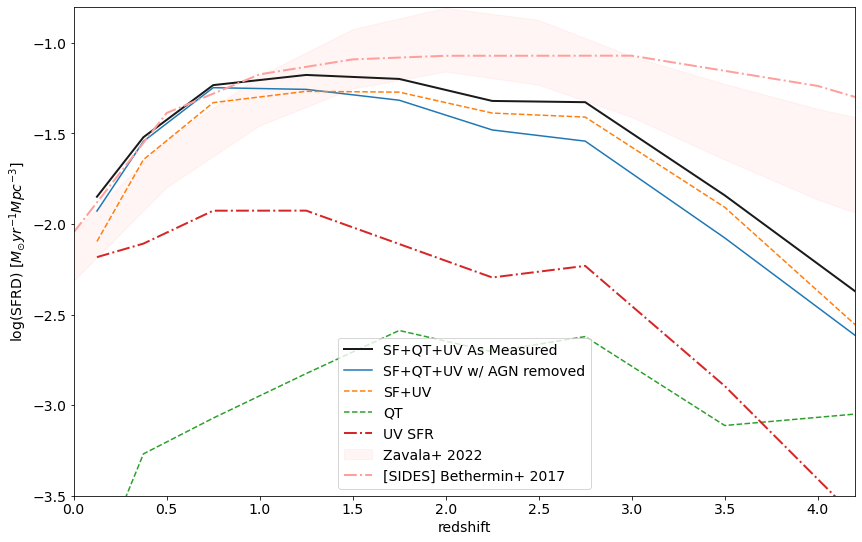

In [76]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

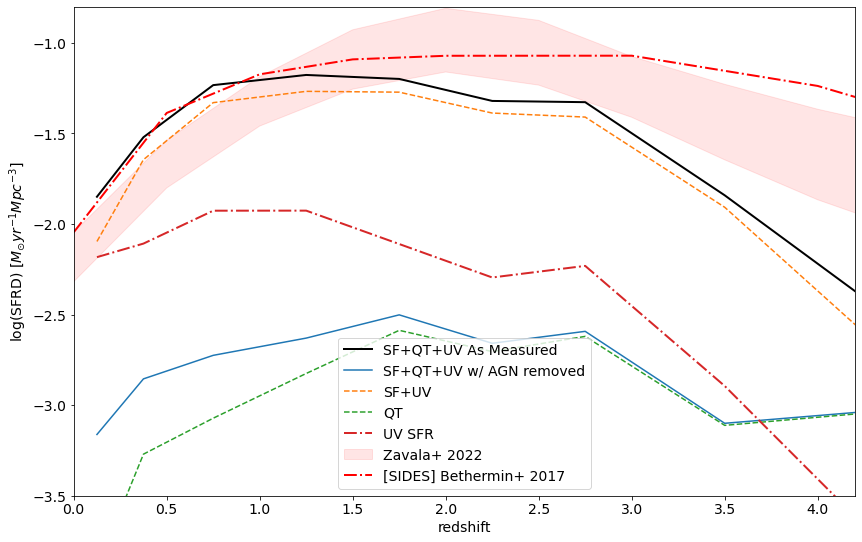

In [58]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

# AGN - induced star-formation?

In [143]:
np.shape(model_cube_sf_agn)

(139396, 3)

In [145]:
model_cube_sf_agn

,z_peak,LMASS,F_ratio
0,0.01000,4.10,0.575678
1,0.01000,4.53,-1.948191
2,0.01000,4.59,0.089953
3,0.01000,4.69,-0.118435
4,0.01000,4.70,-0.161850
...,...,...,...
166627,4.08688,11.99,1.381195
166629,3.87075,12.00,2.164090
166630,2.73762,12.02,1.147090
166631,4.21236,12.12,0.474719


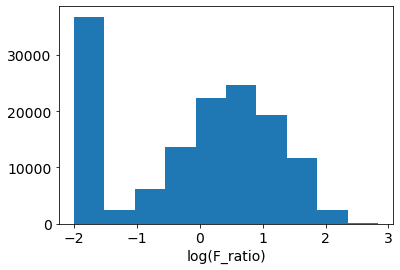

In [162]:
plt.hist(model_cube_sf_agn[-1]);
plt.xlabel('log(F_ratio)');

In [197]:
f_lo = -0
f_hi = 1
idx_lo = model_cube_sf_agn[-1] < f_lo
idx_hi = model_cube_sf_agn[-1] > f_hi
Z_model_sf_lo = Z_model_sf[idx_lo]
M_model_sf_lo = M_model_sf[idx_lo]
Z_model_sf_hi = Z_model_sf[idx_hi]
M_model_sf_hi = M_model_sf[idx_hi]
AGN_model_sf_lo = AGN_model_sf[idx_lo]
AGN_model_sf_hi = AGN_model_sf[idx_hi]

In [198]:
A_combined_model_sf_lo_w_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn[:,idx_lo])
T_combined_model_sf_lo_w_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn[:,idx_lo])

In [199]:
A_combined_model_sf_lo_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf[:,idx_lo])
T_combined_model_sf_lo_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf[:,idx_lo])

In [200]:
A_combined_model_sf_hi_w_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn[:,idx_hi])
T_combined_model_sf_hi_w_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn[:,idx_hi])

In [201]:
A_combined_model_sf_hi_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf[:,idx_hi])
T_combined_model_sf_hi_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf[:,idx_hi])

In [202]:
combined_theta_model_lo_w_agn = A_combined_model_sf_lo_w_agn, np.array(T_combined_model_sf_lo_w_agn / (1+Z_model_sf_lo))

In [203]:
combined_theta_model_lo_agn = A_combined_model_sf_lo_agn, np.array(T_combined_model_sf_lo_agn / (1+Z_model_sf_lo))

In [204]:
combined_theta_model_hi_w_agn = A_combined_model_sf_hi_w_agn, np.array(T_combined_model_sf_hi_w_agn / (1+Z_model_sf_hi))

In [205]:
combined_theta_model_hi_agn = A_combined_model_sf_hi_agn, np.array(T_combined_model_sf_hi_agn / (1+Z_model_sf_hi))

In [206]:
LIR_model_sf_lo_w_agn = fast_LIR(simstack_object, combined_theta_model_lo_w_agn, Z_model_sf_lo)

In [207]:
LIR_model_sf_lo_agn = fast_LIR(simstack_object, combined_theta_model_lo_agn, Z_model_sf_lo)

In [208]:
LIR_model_sf_hi_w_agn = fast_LIR(simstack_object, combined_theta_model_hi_w_agn, Z_model_sf_hi)

In [209]:
LIR_model_sf_hi_agn = fast_LIR(simstack_object, combined_theta_model_hi_agn, Z_model_sf_hi)

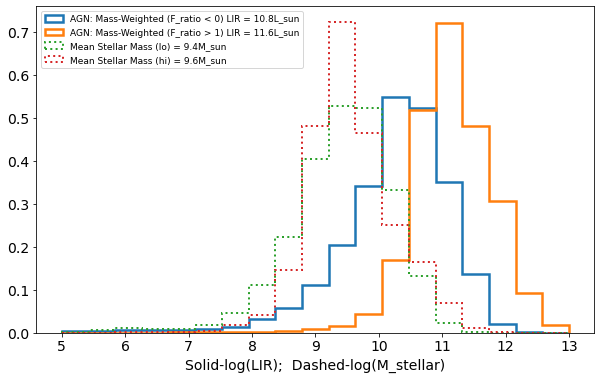

In [210]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
bins_lir = np.linspace(5,13,20)
wlo=None #M_model_sf_lo 
whi=None #M_model_sf_hi 

plt.hist(np.log10(LIR_model_sf_lo_w_agn), bins=bins_lir, ls='-', weights=wlo, density=True,histtype='step',lw=2.5,label='AGN: Mass-Weighted (F_ratio < {0}) LIR = {1:0.1f}L_sun'.format(f_lo,np.log10(np.mean(LIR_model_sf_lo_w_agn))) );
plt.hist(np.log10(LIR_model_sf_hi_w_agn), bins=bins_lir, ls='-', weights=whi, density=True,histtype='step',lw=2.5,label='AGN: Mass-Weighted (F_ratio > {0}) LIR = {1:0.1f}L_sun'.format(f_hi,np.log10(np.mean(LIR_model_sf_hi_w_agn))) );

plt.hist(M_model_sf_lo, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (lo) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_lo)));
plt.hist(M_model_sf_hi, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (hi) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_hi)));

plt.xlabel('Solid-log(LIR);  Dashed-log(M_stellar)')
plt.legend(loc='upper left',fontsize=9);

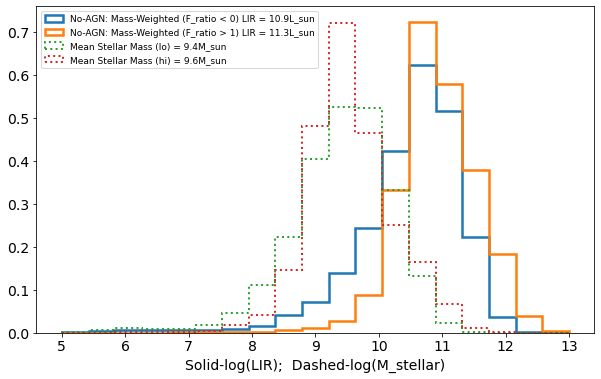

In [211]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
bins_lir = np.linspace(5,13,20)
wlo=None #M_model_sf_lo 
whi=None #M_model_sf_hi 

plt.hist(np.log10(LIR_model_sf_lo_agn), bins=bins_lir, ls='-', weights=wlo, density=True,histtype='step',lw=2.5,label='No-AGN: Mass-Weighted (F_ratio < {0}) LIR = {1:0.1f}L_sun'.format(f_lo,np.log10(np.mean(LIR_model_sf_lo_agn))) );
plt.hist(np.log10(LIR_model_sf_hi_agn), bins=bins_lir, ls='-', weights=whi, density=True,histtype='step',lw=2.5,label='No-AGN: Mass-Weighted (F_ratio > {0}) LIR = {1:0.1f}L_sun'.format(f_hi,np.log10(np.mean(LIR_model_sf_hi_agn))) );

plt.hist(M_model_sf_lo, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (lo) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_lo)));
plt.hist(M_model_sf_hi, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (hi) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_hi)));

plt.xlabel('Solid-log(LIR);  Dashed-log(M_stellar)')
plt.legend(loc='upper left',fontsize=9);

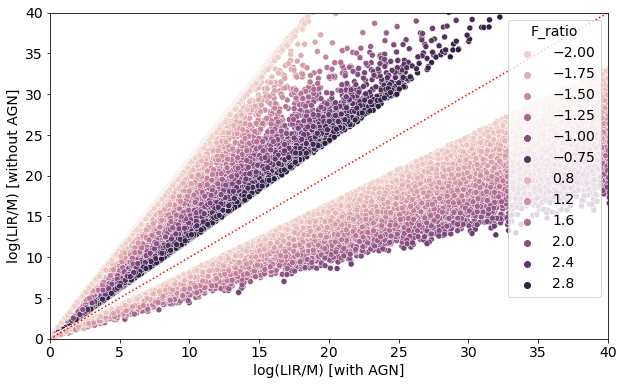

In [196]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
sns.scatterplot(LIR_model_sf_lo_w_agn/10**M_model_sf_lo, LIR_model_sf_lo_agn/10**M_model_sf_lo, hue=AGN_model_sf_lo)
sns.scatterplot(LIR_model_sf_hi_w_agn/10**M_model_sf_hi, LIR_model_sf_hi_agn/10**M_model_sf_hi, hue=AGN_model_sf_hi)
xlim=40
plt.xlim([0,xlim]);
plt.ylim([0,xlim]);
plt.xlabel('log(LIR/M) [with AGN]')
plt.ylabel('log(LIR/M) [without AGN]')
axs.plot([0,xlim],[0,xlim],'r:');


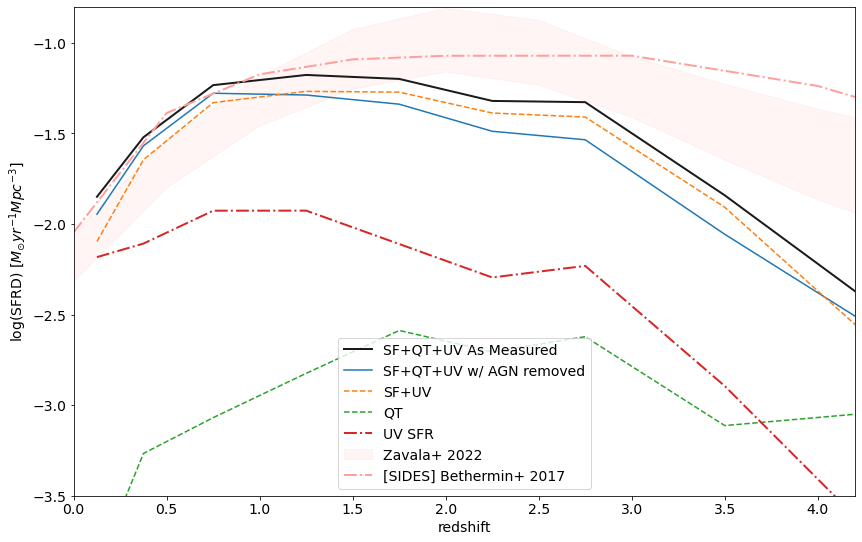

In [126]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt_agn)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

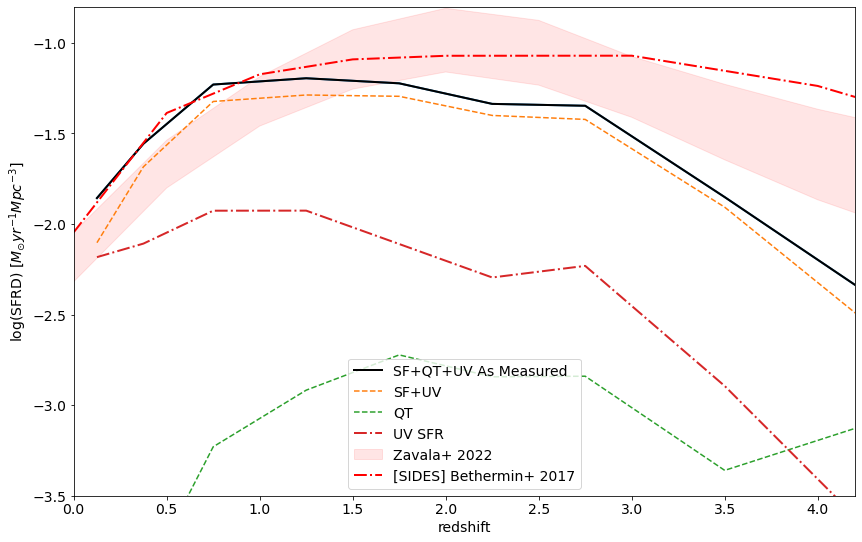

In [61]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol),  lw=2, label=None)
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt_agn)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

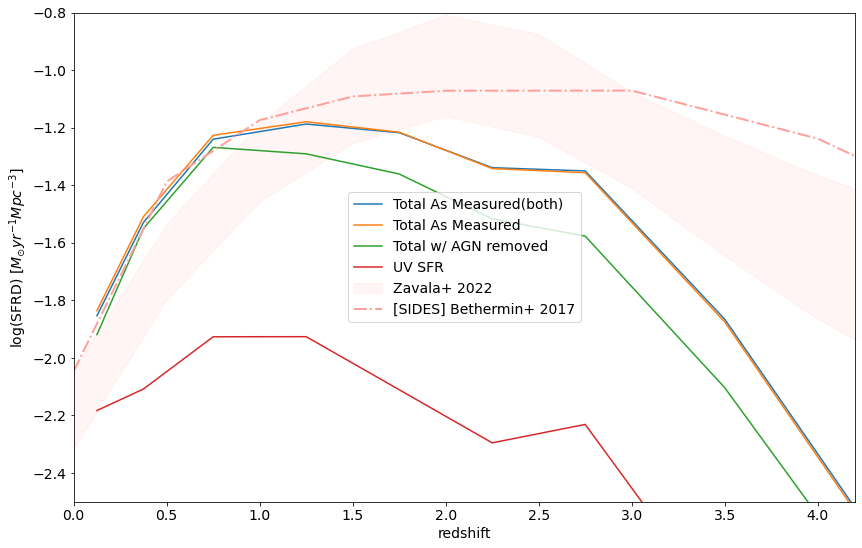

In [99]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured(both)')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_just_sf_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_just_sf)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol),  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

## Now make maps from fits

In [46]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf_agn,T_combined_model_sf_agn/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt_agn,T_combined_model_qt_agn/np.array(1+Z_model_qt))

In [47]:
outmap_dict={}
def write_fits(self,
               mapin,
               map_name,
               path_map=r'C:\Users\viero\Desktop', 
               prefix='model_',
               overwrite=True, 
               show=False):
    
    if show:
        plt.imshow(model_250)

    map_object = self.maps_dict[map_name]
    #path_map = r'D:\maps\cutouts\layers'
    name_map = prefix+str(map_name)+'.fits'

    hd = map_object['header']
    fwhm = map_object['fwhm']
    pix = map_object['pixel_size']
    kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
    tmap = smooth_psf(mapin, kern)
    
    ind_zero = abs(tmap) < 1e-10
    ind_non_zero = mapin != 0
    smap = tmap
    smap -= np.mean(smap[ind_non_zero])
    #smap[ind_zero]=0

    hdu = fits.PrimaryHDU(smap, header=hd)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_map, name_map),overwrite=overwrite)
    outmap_dict[name_map]=smap
    print('{0} written to {1}'.format(name_map,path_map))

In [48]:
for map_key in simmap_dict:
    #write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='mapfit_'+prefix)    
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_and_qt2_convolved_mapfit_z_Trf'+prefix)

sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_mips_24.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_pacs_green.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_pacs_red.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_spire_psw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_spire_plw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfSF_QT__A gt_n35p5_scuba_850.fits written to C:\Users\viero\Desktop


# Decompose LIR into AGN and non-AGN

In [106]:
print(len(A_model))
print(len(T_model))
print(len(Z_model))

139396
139396
139396


In [138]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

In [139]:
theta_model_sf_agn = A_model_sf_agn, T_model_sf_agn / (1+Z_model_sf)
theta_model_qt_agn = A_model_qt_agn, T_model_qt_agn / (1+Z_model_qt)
theta_model_sf = A_model_sf, T_model_sf / (1+Z_model_sf)
theta_model_qt = A_model_qt, T_model_qt / (1+Z_model_qt)

In [140]:
LIR_model_sf_agn = fast_LIR(simstack_object, theta_model_sf_agn, Z_model_sf)

In [141]:
LIR_model_sf = fast_LIR(simstack_object, theta_model_sf, Z_model_sf)

In [142]:
LIR_model_qt_agn = fast_LIR(simstack_object, theta_model_qt_agn, Z_model_qt)

In [143]:
LIR_model_qt = fast_LIR(simstack_object, theta_model_qt, Z_model_qt)

In [144]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=10000, replace=False)

In [145]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=10000, replace=False)

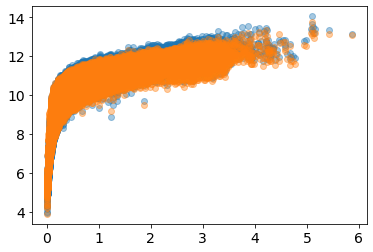

In [346]:
plt.scatter(Z_model_sf, np.log10(LIR_model_sf_agn), alpha=0.4);
plt.scatter(Z_model_sf, np.log10(LIR_model_sf), alpha=0.4);

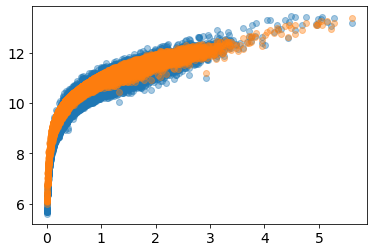

In [345]:
plt.scatter(Z_model_qt, np.log10(LIR_model_qt_agn), alpha=0.4);
plt.scatter(Z_model_qt, np.log10(LIR_model_qt), alpha=0.4);

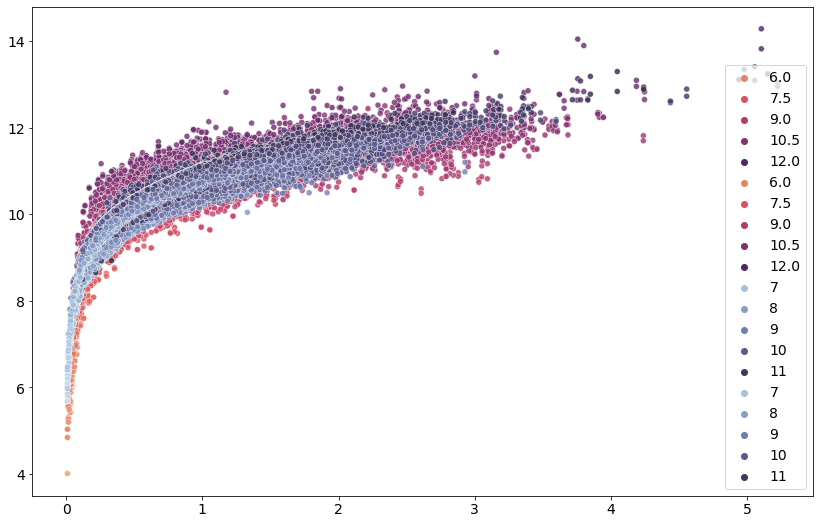

In [146]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
sns.scatterplot(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), markers='o', hue=M_model_sf[idx_sample_sf], palette='flare', alpha=0.8);
sns.scatterplot(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), markers='s', hue=M_model_sf[idx_sample_sf], palette='flare',alpha=0.8);

sns.scatterplot(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt_agn[idx_sample_qt]), markers='o', hue=M_model_qt[idx_sample_qt], palette='ch:s=.25,rot=-.25', alpha=0.8);
sns.scatterplot(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), markers='s', hue=M_model_qt[idx_sample_qt], palette='ch:s=.25,rot=-.25', alpha=0.8);

In [200]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_sf_agn = np.zeros(len(zbins)-1)
binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt_agn = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)

binned_uv_sfr_sf = np.zeros(len(zbins)-1)
binned_uv_sfr_qt = np.zeros(len(zbins)-1)

binned_uv_whole = np.zeros(len(zbins)-1)

binned_vol = np.zeros(len(zbins)-1)
area_deg2 = 1.8 #1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    
    binned_lir_sf_agn[iz] = np.sum(LIR_model_sf_agn[idx_z_sf],axis=0)
    binned_lir_sf[iz] = np.sum(LIR_model_sf[idx_z_sf],axis=0)
    binned_lir_qt_agn[iz] = np.sum(LIR_model_qt_agn[idx_z_qt],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt[idx_z_qt],axis=0)
    
    binned_uv_sfr_sf[iz] = np.sum(uv_sfr_sf[idx_z_sf])
    binned_uv_sfr_qt[iz] = np.sum(uv_sfr_qt[idx_z_qt])
    
    idx_z_whole = (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] > zbins[iz]) & (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] <= zbins[iz+1])
    binned_uv_whole[iz] = np.sum(simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV'][idx_z_whole])
    
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

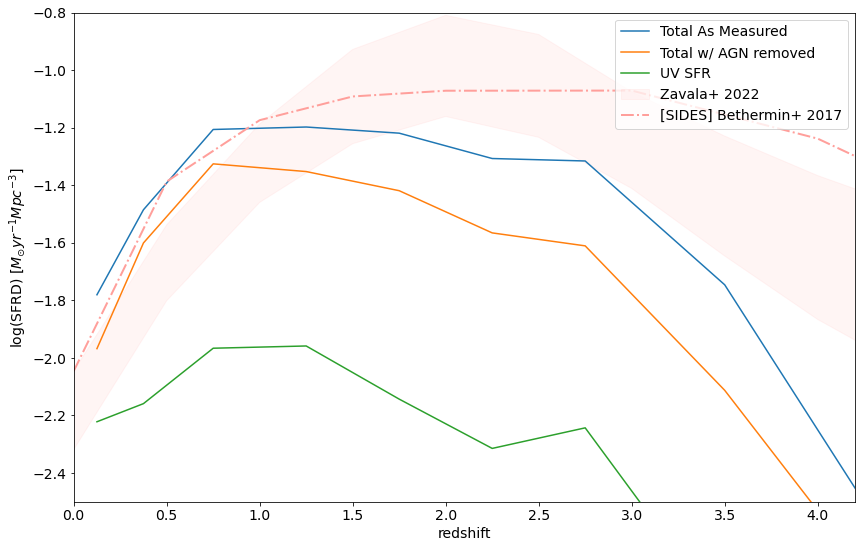

In [202]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))
#plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf_agn /binned_vol),  label='SFGs As Measured')
#plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf /binned_vol), label='SFG w/ AGN removed')

#plt.plot(binned_z, np.log10(binned_uv_whole /binned_vol),  label='UV SFR, all')

#plt.plot(binned_z, np.log10(binned_lir_qt_agn /binned_vol),  label='QT As Measured')
#plt.plot(binned_z, np.log10(binned_lir_qt /binned_vol), label='QT w/ AGN removed')

#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

plt.plot(binned_z, np.log10(binned_uv_sfr_sf /binned_vol),  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

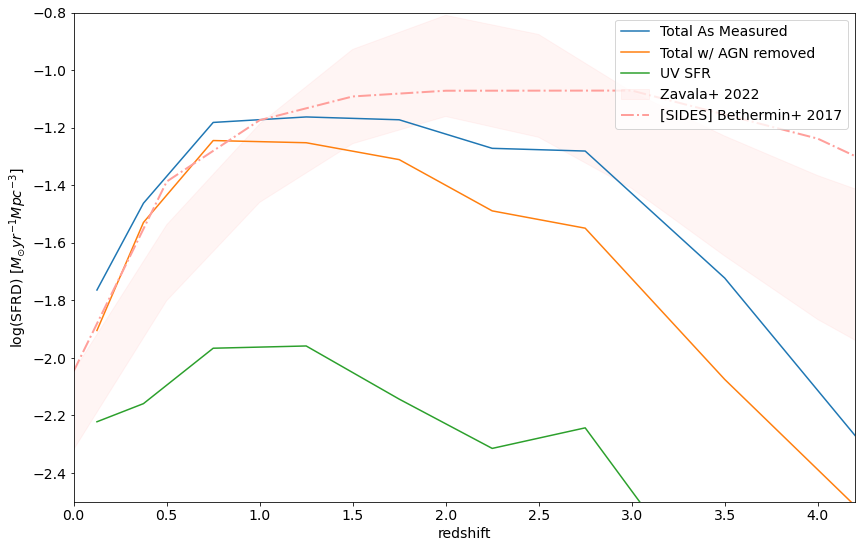

In [203]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))
#plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf_agn /binned_vol),  label='SFGs As Measured')
#plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf /binned_vol), label='SFG w/ AGN removed')

#plt.plot(binned_z, np.log10(binned_uv_whole /binned_vol),  label='UV SFR, all')

#plt.plot(binned_z, np.log10(binned_lir_qt_agn /binned_vol),  label='QT As Measured')
#plt.plot(binned_z, np.log10(binned_lir_qt /binned_vol), label='QT w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

plt.plot(binned_z, np.log10(binned_uv_sfr_sf /binned_vol),  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

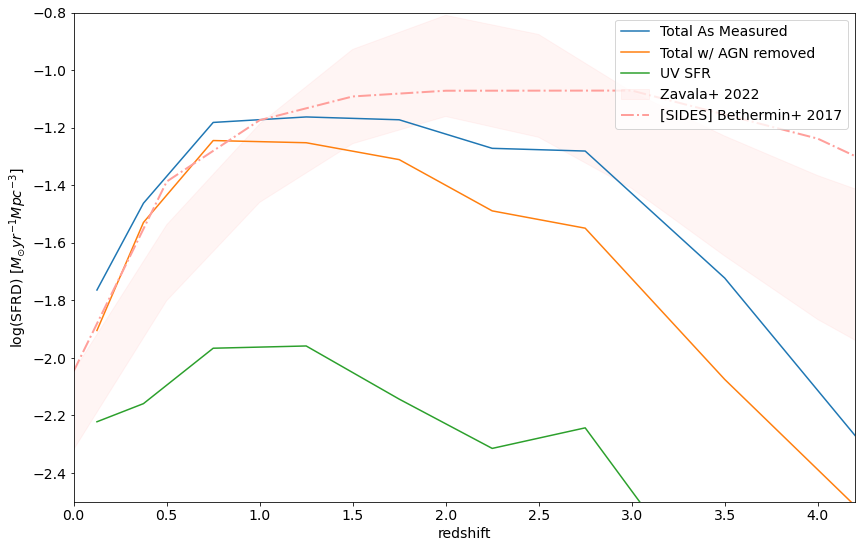

In [201]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol),  label='Total As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='Total w/ AGN removed')

plt.plot(binned_z, np.log10(binned_uv_sfr_sf /binned_vol),  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

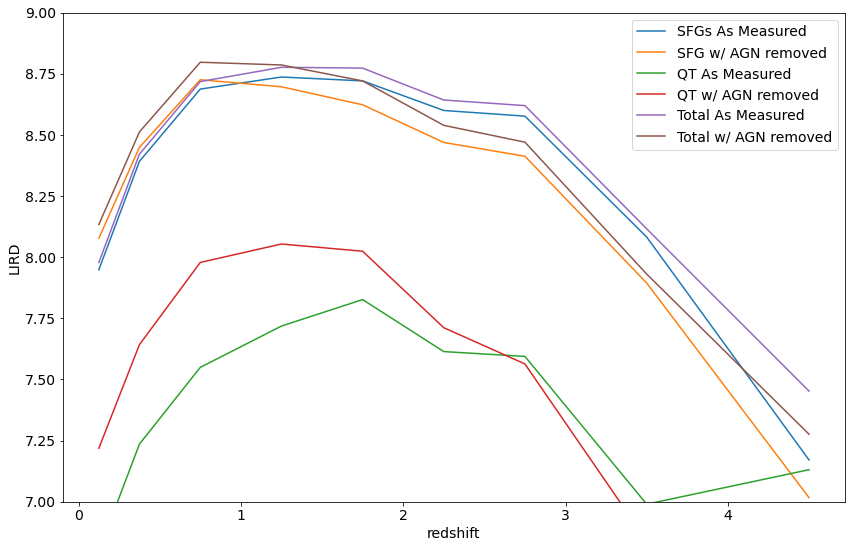

In [359]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.plot(binned_z, np.log10(binned_lir_sf_agn /binned_vol),  label='SFGs As Measured')
plt.plot(binned_z, np.log10(binned_lir_sf /binned_vol), label='SFG w/ AGN removed')
plt.plot(binned_z, np.log10(binned_lir_qt_agn /binned_vol),  label='QT As Measured')
plt.plot(binned_z, np.log10(binned_lir_qt /binned_vol), label='QT w/ AGN removed')

plt.plot(binned_z, np.log10((binned_lir_sf_agn+binned_lir_qt_agn) /binned_vol),  label='Total As Measured')
plt.plot(binned_z, np.log10((binned_lir_sf+binned_lir_qt) /binned_vol), label='Total w/ AGN removed')
plt.xlabel('redshift')
plt.ylabel('LIRD');
plt.ylim([7,9]);
plt.legend();